# 応用情報工学演習：Scikit-Learnマスターコース
## 実践編 配布用コードファイル

#### 基本ライブラリの読み込み

In [9]:
import os, sys
import glob

import warnings
warnings.simplefilter('ignore')

import numpy as np
from sklearn.metrics import accuracy_score
from PIL import Image

# 自作モジュールのインポート
from utils.train import fit, evaluate_history, generate_pseudo_labels ,torch_seed, fit_self_train
from utils.dataset import MyDataset

# 必要ライブラリのインポート
import matplotlib.pyplot as plt

# PyTorch関連ライブラリのインポート
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import models

# warning表示off
import warnings
warnings.simplefilter('ignore')

# デフォルトフォントサイズ変更
plt.rcParams['font.size'] = 14

# デフォルトグラフサイズ変更
plt.rcParams['figure.figsize'] = (6,6)

# デフォルトで方眼表示ON
plt.rcParams['axes.grid'] = True

# numpyの表示桁数設定
np.set_printoptions(suppress=True, precision=5)

np.random.seed(1)

### Cudaのチェック

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


#### データ読み込み関数

In [11]:
#-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-#
#                               このセルは変更を禁止します                                  #
#-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-#
#-------------------------------------------------------------------------------------------#
#-                                  データ読み込み関数                                     -#
#-------------------------------------------------------------------------------------------#
def load_data_(root_dir='../data/gw_dataset'):
    """
    グループワーク用　学習用データ読み込み関数

    Args:
        * root_dir: 配布したgw_datasetへのパスを指定する (default: '../data/gw_dataset')
        
    Output:
        * X_train:  正解ラベル付き学習用画像   shape: (140x150,528)
                    1行あたり、画像1枚の画素値を格納したnp.array
                    画像140枚、各画像224x224=150,528次元のベクトル
                    
        * y_train:  X_trainの正解ラベル        shape: (140, )
                    クラス数は7　140枚分のクラスラベル（0～6）の整数が格納されている
        
        * X_trainu: 正解ラベルなし学習用画像   shape: (210x150,528)
                    形式はX_trainと同じ
                    
        * X_val:   正解ラベル付き検証用画像   shape: (70x150,528)
                    形式はX_trainと同じ
                    
        * y_val:    X_valの正解ラベル          shape: (70, )
                    形式はy_valと同じ                             
    """
    
    #----------------- 学習用データの読み込み -------------------#
    train_paths = sorted(glob.glob(os.path.join(root_dir, "train", "*.png")))
    
    X_train = np.array([np.array(Image.open(p)).astype(np.float32).ravel() for p in train_paths])
    y_train = np.load(os.path.join(root_dir, "y_train.npy"))

    #------------ ラベルなし学習用データの読み込み --------------#
    trainu_paths = sorted(glob.glob(os.path.join(root_dir, "train-u", "*.png")))
    X_trainu = np.array([np.array(Image.open(p)).astype(np.float32).ravel() for p in trainu_paths])
    
    #----------------- 検証用データの読み込み -------------------#
    val_paths = sorted(glob.glob(os.path.join(root_dir,"val", "*.png")))
    X_val = np.array([np.array(Image.open(p)).astype(np.float32).ravel() for p in val_paths])
    y_val = np.load(os.path.join(root_dir, "y_val.npy"))

    return X_train, y_train, X_trainu, X_val, y_val

In [12]:
### データ読み込み関数の実行
X_train, y_train, X_trainu, X_val, y_val = load_data_() # すべて必要な場合
print(X_train.shape, y_train.shape, X_trainu.shape, X_val.shape, y_val.shape)

# X_train, y_train, _, X_val, y_val = load_data_() # いらないデータがある場合
# print(X_train.shape, y_train.shape, X_val.shape, y_val.shape)

(140, 150528) (140,) (210, 150528) (70, 150528) (70,)


#### 評価関数

In [13]:
#-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-#
#                               このセルは変更を禁止します                                  #
#-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-#
#-------------------------------------------------------------------------------------------#
#-                                       評価関数                                          -#
#-------------------------------------------------------------------------------------------#

def eval_(y_pred):
    """
    グループワーク用　評価関数
    実行する前にy_valがglobalスコープに読み込まれている必要がある

    Args:
        * y_pred:   識別結果　y_valと同形式・同shapeでなければならない
    """

    try:
        y_val
    except NameError as e:
        print("y_valが読み込まれていません")
        
    assert y_pred.shape == y_val.shape, 'y_predとy_valのサイズが一致しません'
    
    print("valデータでの識別精度:{0:.3f}".format(accuracy_score(y_val, y_pred)))

### データの確認

In [14]:
# 分類先クラスのリスト作成
classes = [ '0', '1', '2', '3', '4', '5', '6']

# データを復元
X_train_reshaped = X_train.reshape(-1, 224, 224, 3)
X_val_reshaped = X_val.reshape(-1, 224, 224, 3)
X_trainu_reshaped = X_trainu.reshape(-1, 224, 224, 3)

# データセット作成
train_data = MyDataset(X_train_reshaped, y_train, type='train')
val_data = MyDataset(X_val_reshaped, y_val, type='val')
trainu_data = MyDataset(X_trainu_reshaped, None, type='unlabeled')

# データ件数確認
print(f'訓練データ: {len(train_data)}件')
print(f'ラベルなし訓練データ: {len(trainu_data)}件')
print(f'検証データ: {len(val_data)}件')

# データローダー作成
batch_size = 70
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
unlabeled_loader = DataLoader(trainu_data, batch_size=batch_size, shuffle=False)


訓練データ: 140件
ラベルなし訓練データ: 210件
検証データ: 70件


### モデルの定義

In [15]:
# 試行回数
num_epochs = 1000

# SelfTrainingの回数
num_pseudo_labeling = 5

# historyファイルを初期化する
history = np.zeros((0, 5), dtype=float)

# 学習モデル定義
net = models.resnet18(pretrained = True)
net.fc = nn.Linear(in_features=net.fc.in_features, out_features=7)  # 7クラスに変更

# 乱数初期化
torch_seed()

# GPUの利用
net = net.to(device)

# 学習率
lr = 0.001

# 損失関数定義
criterion = nn.CrossEntropyLoss()

# 最適化関数定義
optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9)

### pseudo_labelingと学習を繰り返す

In [16]:
# 0. 初期トレーニング
print(f"\n=== First Training ===\n")
history = fit(
    net=net,
    optimizer=optimizer,
    criterion=criterion,
    num_epochs=1000,
    train_loader=train_loader,
    test_loader=val_loader,
    device=device,
    history=history
)

for i in range(num_pseudo_labeling):
    print(f"\n=== ", i+1 ," Retraining ===\n")
    # 1. 擬似ラベルの生成
    pseudo_labels = generate_pseudo_labels(net, unlabeled_loader, device)

    # 2. 擬似ラベル付きデータセットを作成
    pseudo_labeled_dataset = MyDataset(X_trainu_reshaped, pseudo_labels.numpy(), type='unlabeled')

    # 3. 新しいデータローダーを作成
    pseudo_labeled_loader = DataLoader(pseudo_labeled_dataset, batch_size=batch_size, shuffle=True)

    # 4. 再トレーニングを実行
    history = fit_self_train(
        net=net,
        optimizer=optimizer,
        criterion=criterion,
        num_epochs=num_epochs,
        train_loader=train_loader,
        unlabeled_loader=pseudo_labeled_loader,
        test_loader=val_loader,
        device=device,
        history=history,
        alpha_init=None
    )


=== First Training ===

Epoch 1/1000: Train Loss: 0.0294, Train Acc: 0.1929, Val Loss: 0.0304, Val Acc: 0.1571
Epoch 101/1000: Train Loss: 0.0004, Train Acc: 1.0000, Val Loss: 0.0091, Val Acc: 0.8000
Epoch 201/1000: Train Loss: 0.0002, Train Acc: 1.0000, Val Loss: 0.0082, Val Acc: 0.8000
Epoch 301/1000: Train Loss: 0.0001, Train Acc: 1.0000, Val Loss: 0.0077, Val Acc: 0.8143
Epoch 401/1000: Train Loss: 0.0001, Train Acc: 1.0000, Val Loss: 0.0075, Val Acc: 0.8286
Epoch 501/1000: Train Loss: 0.0001, Train Acc: 1.0000, Val Loss: 0.0074, Val Acc: 0.8286
Epoch 601/1000: Train Loss: 0.0001, Train Acc: 1.0000, Val Loss: 0.0072, Val Acc: 0.8286
Epoch 701/1000: Train Loss: 0.0000, Train Acc: 1.0000, Val Loss: 0.0072, Val Acc: 0.8286
Epoch 801/1000: Train Loss: 0.0000, Train Acc: 1.0000, Val Loss: 0.0071, Val Acc: 0.8286
Epoch 901/1000: Train Loss: 0.0000, Train Acc: 1.0000, Val Loss: 0.0071, Val Acc: 0.8429

===  1  Retraining ===

Epoch 1001/2000: Train Loss: 0.0022, Train Acc: 1.0000, Val Lo

[初期状態] loss: 0.03036, accuracy: 0.15714
[最終状態] loss: 0.00613, accuracy: 0.85714


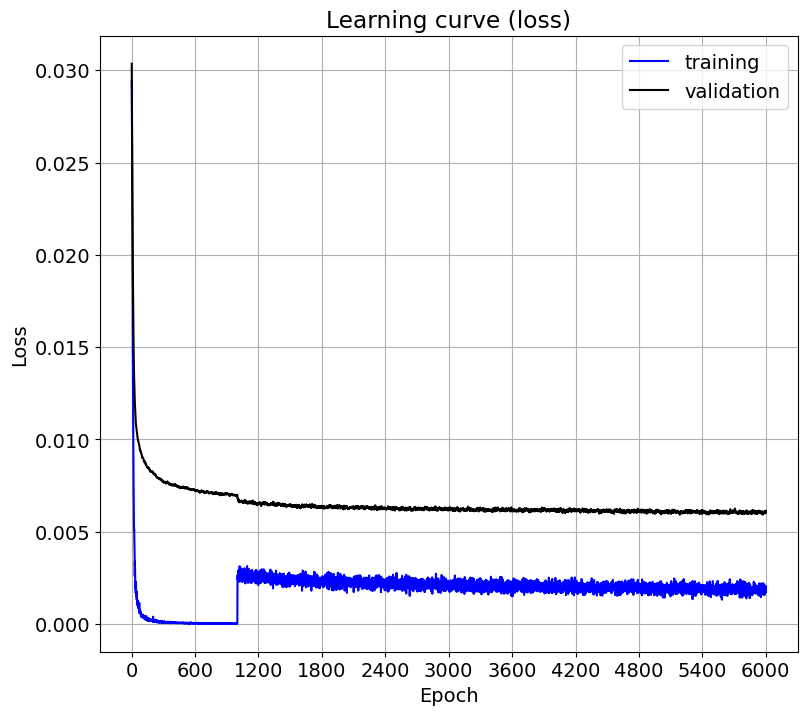

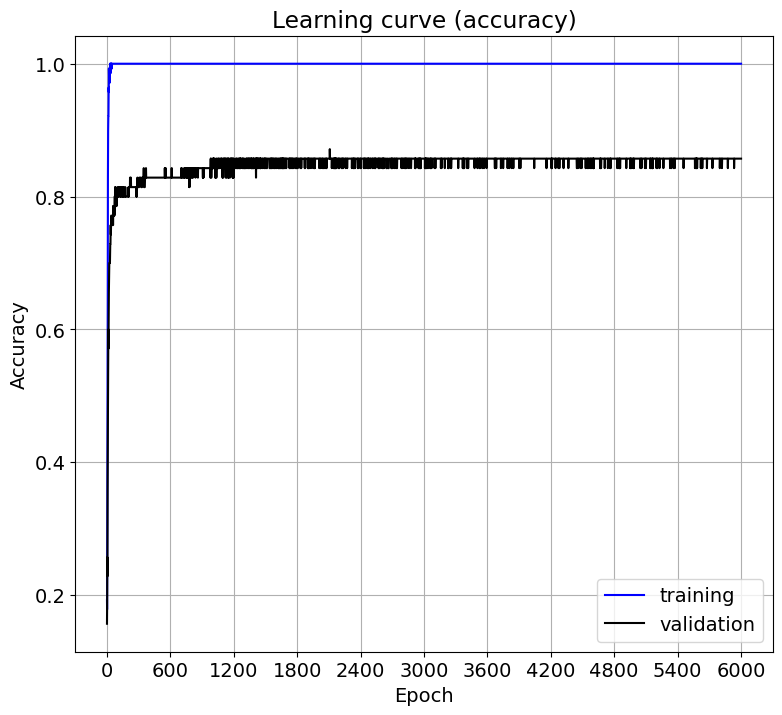

In [17]:
# 結果確認
evaluate_history(history)

### モデルの保存

In [18]:
path = 'model.pth'
torch.save(net.state_dict(), path)